In [2]:
## Imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore

from src.data_processing.lstm_data_preprocessing import get_token_features, get_sliding_windows
from src.data_processing.loader import load_token_data
from src.data_processing.processor import remove_price_anomalies
from src.visualisation.price_plotter import plot_token_price

In [3]:
# Load and prep data

token_address = "WUb891xiehvvaDURF1r5ZBcbKULPQHcSnNtLfywpump"
sequence_length = 10
# Load data
df = load_token_data(token_address)
    
# Clean data for price features
cleaned_df = remove_price_anomalies(df)

feature_matrix = get_token_features(token_address)

X, y = get_sliding_windows(feature_matrix, sequence_length=sequence_length, prediction_horizon=1)

# Normalize the features (important for LSTM models)
# Apply scaling only to the features (not the targets)
feature_scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape X to 2D for scaling then back to 3D
num_samples, time_steps, features = X.shape
X_reshaped = X.reshape(num_samples * time_steps, features)
X_scaled = feature_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale the target variable y
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)


Using these changes: [0.02466509]
We get cumulative change of:  0.024665093965294593
vs adding way
We get cumulative change of:  0.024665093965294593
Using these changes: [-0.00458034]
We get cumulative change of:  -0.004580335749178155
vs adding way
We get cumulative change of:  -0.004580335749178155
Using these changes: [-0.00031502]
We get cumulative change of:  -0.00031501794734145605
vs adding way
We get cumulative change of:  -0.00031501794734145605
Using these changes: [0.01333806]
We get cumulative change of:  0.013338059815864112
vs adding way
We get cumulative change of:  0.013338059815864112
Using these changes: [-0.00275449]
We get cumulative change of:  -0.0027544877140937007
vs adding way
We get cumulative change of:  -0.0027544877140937007
Using these changes: [0.00667902]
We get cumulative change of:  0.006679020855510087
vs adding way
We get cumulative change of:  0.006679020855510087
Using these changes: [0.0022684]
We get cumulative change of:  0.002268399065225246
v

In [4]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - predicting the price change

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get real values
y_pred_actual = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test)

# Evaluate the model
mse = np.mean((y_pred_actual - y_test_actual) ** 2)
print(f"Mean Squared Error: {mse}")

c:\Users\matth\Uni Work\CM3203 - Individual Project\Project Environment\CM3203-Venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0206 - val_loss: 0.0015
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 11/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 12/100
115/115 ━━━━━━━━━━━━━━━

In [5]:
# Modified MAPE calculation with safeguards
def calculate_mape(y_true, y_pred):
    # Filter out zeros in actual values to avoid division by zero
    mask = y_true.flatten() != 0
    if not np.any(mask):  # If all values are zero
        return "Cannot calculate MAPE: All actual values are zero"
    
    # Calculate MAPE only for non-zero actual values
    percentage_errors = np.abs((y_true.flatten()[mask] - y_pred.flatten()[mask]) / y_true.flatten()[mask]) * 100
    
    # Remove infinite or extremely large values (optional)
    filtered_errors = percentage_errors[~np.isinf(percentage_errors) & (percentage_errors < 1000)]
    
    if len(filtered_errors) == 0:
        return "Cannot calculate meaningful MAPE: Errors too large or undefined"
    
    return np.mean(filtered_errors)

# Using the function
mape_value = calculate_mape(y_test_actual, y_pred_actual)
print(f"Mean Absolute Percentage Error: {mape_value}%")

Mean Absolute Percentage Error: 146.8393039329924%


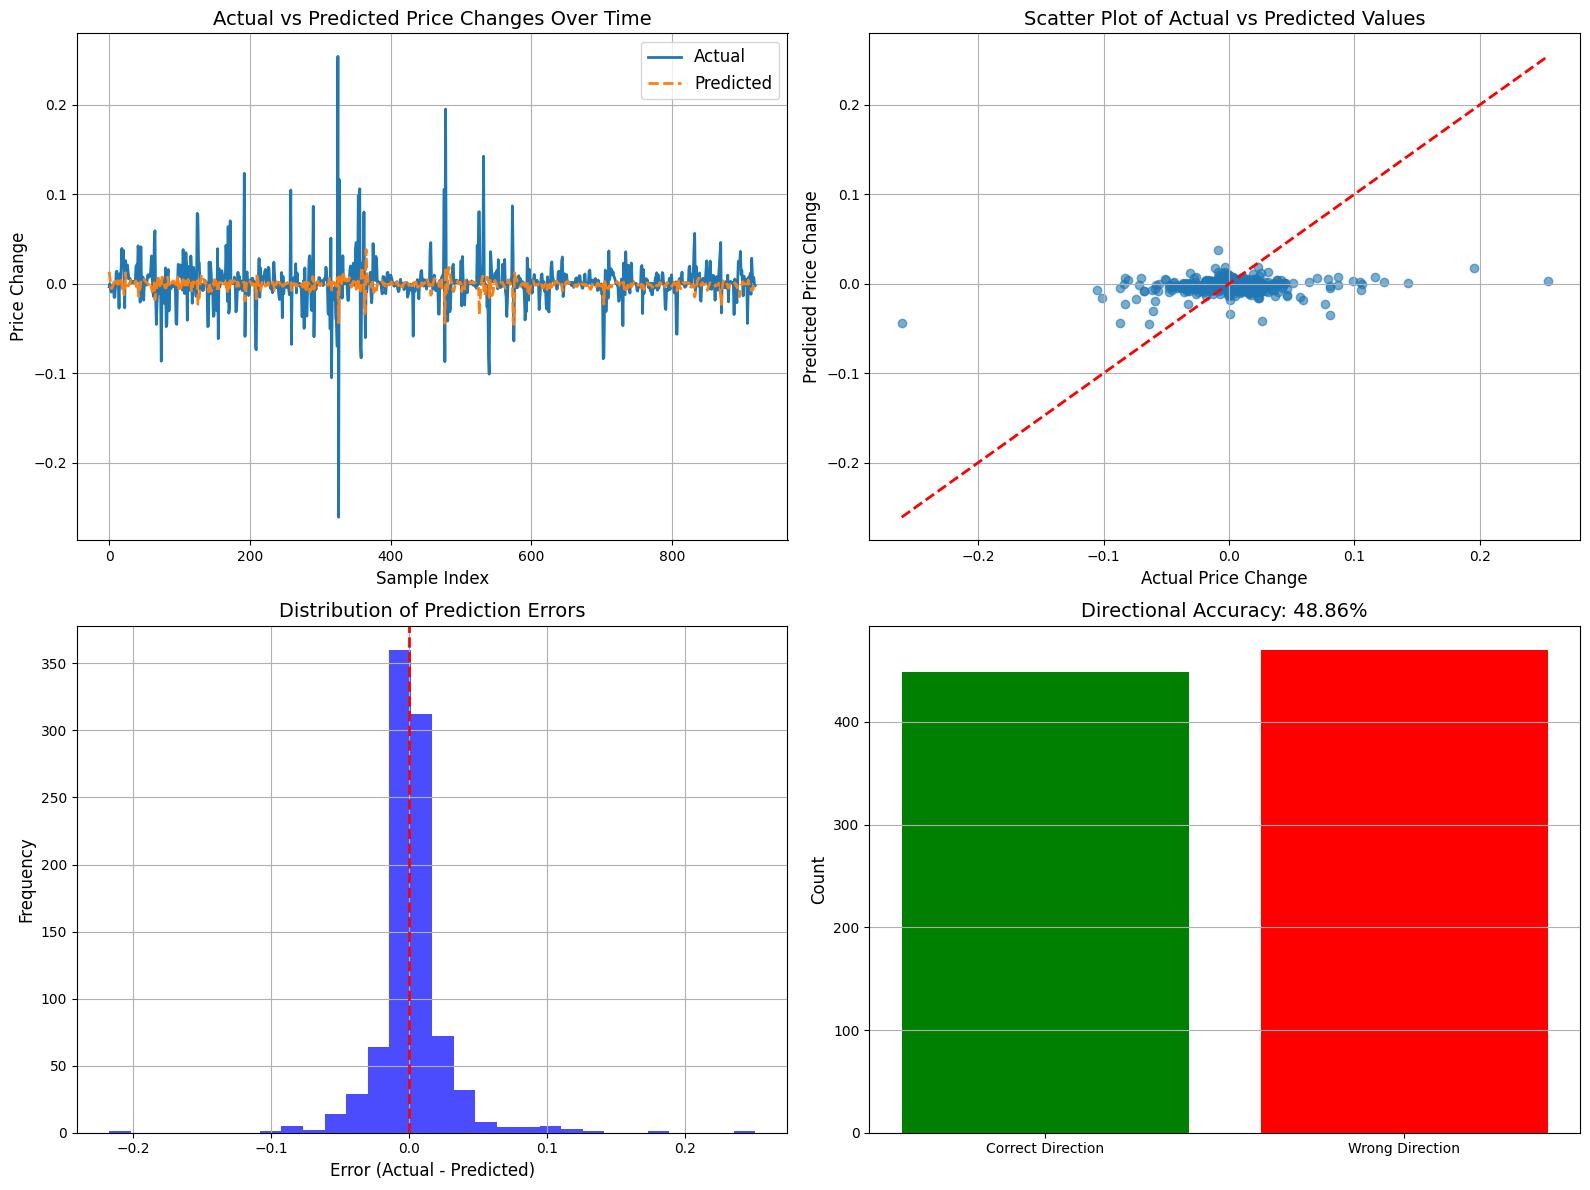

In [6]:
# Plot actual vs predicted

def plot_actual_vs_predicted(y_test_actual, y_pred_actual):
    """
    Create comprehensive plots comparing actual vs predicted price changes.
    
    Parameters:
    y_test_actual - numpy array of actual price changes
    y_pred_actual - numpy array of predicted price changes
    """
    # Ensure inputs are flattened
    y_test_actual = y_test_actual.flatten()
    y_pred_actual = y_pred_actual.flatten()
    
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Time series plot of actual vs predicted values
    axs[0, 0].plot(y_test_actual, label='Actual', linewidth=2)
    axs[0, 0].plot(y_pred_actual, label='Predicted', linewidth=2, linestyle='--')
    axs[0, 0].set_title('Actual vs Predicted Price Changes Over Time', fontsize=14)
    axs[0, 0].set_xlabel('Sample Index', fontsize=12)
    axs[0, 0].set_ylabel('Price Change', fontsize=12)
    axs[0, 0].legend(fontsize=12)
    axs[0, 0].grid(True)
    
    # 2. Scatter plot of actual vs predicted with diagonal line
    axs[0, 1].scatter(y_test_actual, y_pred_actual, alpha=0.6)
    
    # Add diagonal line (perfect predictions)
    min_val = min(y_test_actual.min(), y_pred_actual.min())
    max_val = max(y_test_actual.max(), y_pred_actual.max())
    axs[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    axs[0, 1].set_title('Scatter Plot of Actual vs Predicted Values', fontsize=14)
    axs[0, 1].set_xlabel('Actual Price Change', fontsize=12)
    axs[0, 1].set_ylabel('Predicted Price Change', fontsize=12)
    axs[0, 1].grid(True)
    
    # 3. Histogram of errors
    errors = y_test_actual - y_pred_actual
    axs[1, 0].hist(errors, bins=30, alpha=0.7, color='blue')
    axs[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axs[1, 0].set_title('Distribution of Prediction Errors', fontsize=14)
    axs[1, 0].set_xlabel('Error (Actual - Predicted)', fontsize=12)
    axs[1, 0].set_ylabel('Frequency', fontsize=12)
    axs[1, 0].grid(True)
    
    # 4. Directional accuracy visualization
    correct_direction = np.sign(y_test_actual) == np.sign(y_pred_actual)
    axs[1, 1].bar(['Correct Direction', 'Wrong Direction'], 
                 [np.sum(correct_direction), np.sum(~correct_direction)],
                 color=['green', 'red'])
    
    directional_accuracy = np.mean(correct_direction) * 100
    axs[1, 1].set_title(f'Directional Accuracy: {directional_accuracy:.2f}%', fontsize=14)
    axs[1, 1].set_ylabel('Count', fontsize=12)
    axs[1, 1].grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test_actual, y_pred_actual)

In [15]:
# Evaluate accuracy of predictions for the top x percent of predictions by size of change
# 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 
def compare_estimate_to_real(y_test_actual, y_pred_actual, percentage=5):
    """
    Create comprehensive plots comparing actual vs predicted price changes.
    
    Parameters:
    y_test_actual - numpy array of actual price changes
    y_pred_actual - numpy array of predicted price changes
    """
    # Ensure inputs are flattened
    y_test_actual = y_test_actual.flatten()
    y_pred_actual = y_pred_actual.flatten()

    # Find the indices of the top positive and negative predicted changes
    num_to_highlight = int(len(y_pred_actual) * percentage / 100)
    
    # Sort by absolute value to get largest changes in either direction
    sorted_indices = np.argsort(np.abs(y_pred_actual))[::-1]
    top_indices = sorted_indices[:num_to_highlight]

    top_predicted = y_pred_actual[top_indices]
    real_equivalents = y_test_actual[top_indices]

     # Compute error metrics
    overall_mae = mean_absolute_error(y_test_actual, y_pred_actual)
    top_mae = mean_absolute_error(real_equivalents, top_predicted)

    overall_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    top_rmse = np.sqrt(mean_squared_error(real_equivalents, top_predicted))

    overall_r2 = r2_score(y_test_actual, y_pred_actual)
    top_r2 = r2_score(real_equivalents, top_predicted)

    # Directional Accuracy: % of cases where sign of predicted matches actual
    overall_directional_accuracy = np.mean(np.sign(y_pred_actual) == np.sign(y_test_actual))
    top_directional_accuracy = np.mean(np.sign(top_predicted) == np.sign(real_equivalents))

    print(f"Overall MAE: {overall_mae:.4f}, Top {percentage}% MAE: {top_mae:.4f}")
    print(f"Overall RMSE: {overall_rmse:.4f}, Top {percentage}% RMSE: {top_rmse:.4f}")
    print(f"Overall R²: {overall_r2:.4f}, Top {percentage}% R²: {top_r2:.4f}")
    print(f"Overall Directional Accuracy: {overall_directional_accuracy:.2%}")
    print(f"Top {percentage}% Directional Accuracy: {top_directional_accuracy:.2%}")


compare_estimate_to_real(y_test_actual, y_pred_actual)
    

Overall MAE: 0.0143, Top 5% MAE: 0.0423
Overall RMSE: 0.0259, Top 5% RMSE: 0.0600
Overall R²: 0.0243, Top 5% R²: 0.1022
Overall Directional Accuracy: 48.86%
Top 5% Directional Accuracy: 42.22%


3685


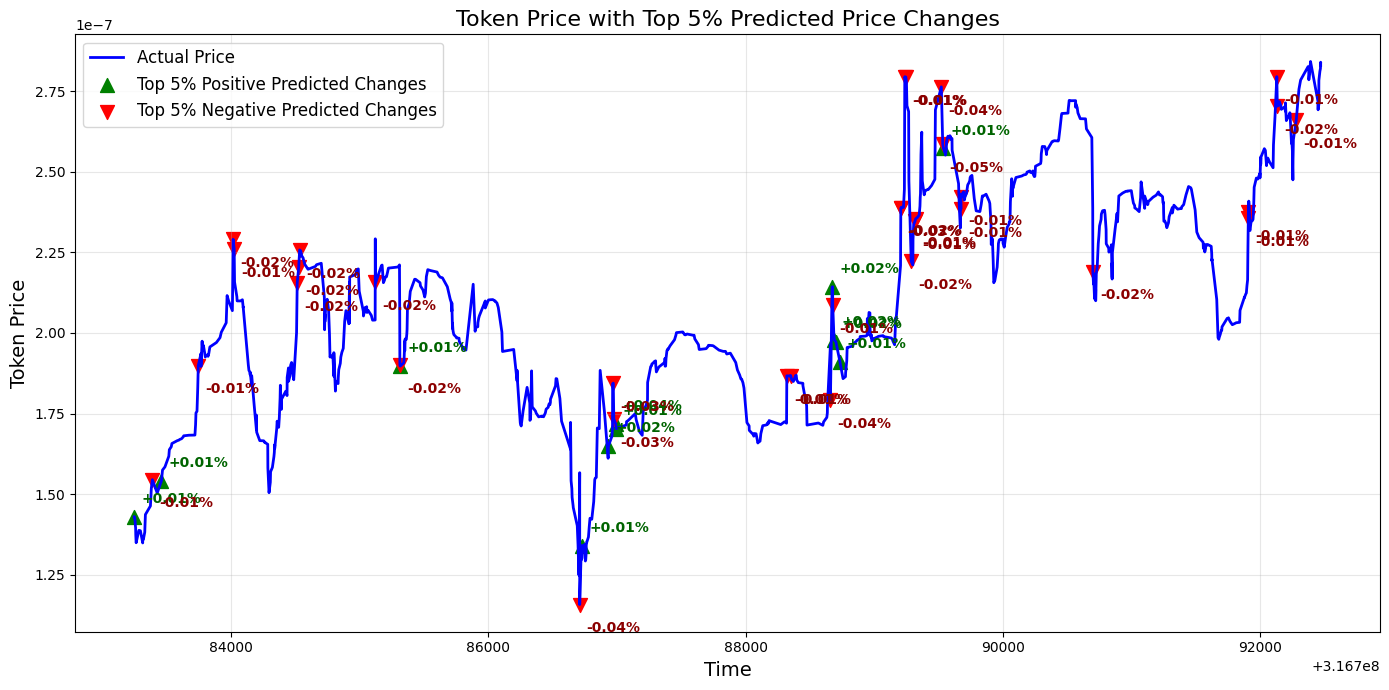

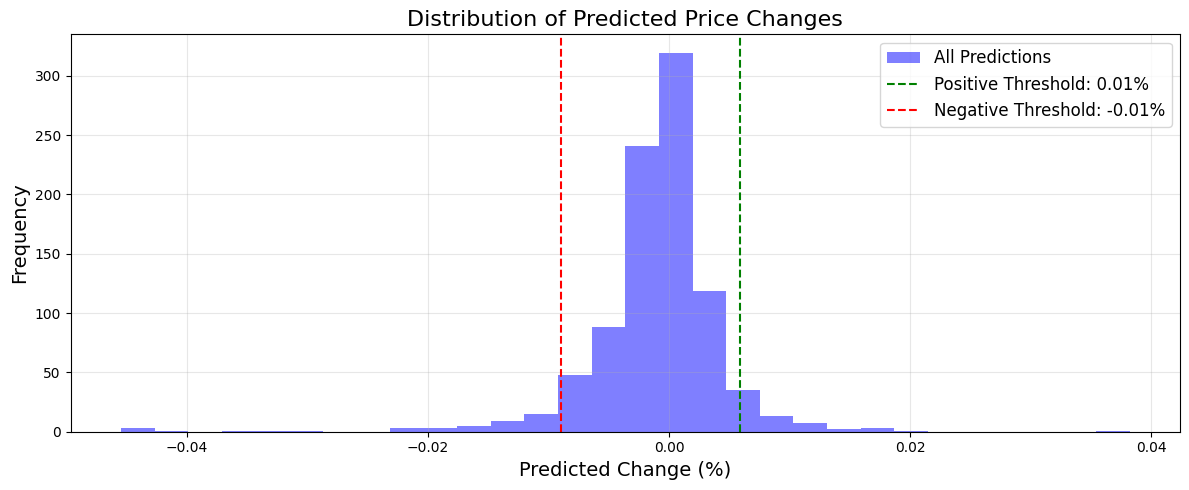

In [ ]:
def plot_top_predicted_price_changes(cleaned_df, y_pred_actual, percentage=10):
    """
    Plot the actual price chart and highlight where the model predicts the largest price changes.
    
    Parameters:
    cleaned_df - The original DataFrame with token prices
    y_pred_actual - numpy array of predicted price changes (percentage)
    percentage - Top percentage of price changes to highlight (default: 10%)
    """
    import matplotlib.dates as mdates
    from matplotlib.patches import Rectangle
    
    # Flatten the predictions if needed
    y_pred_actual = y_pred_actual.flatten()
    
    # Determine where the test predictions start in the cleaned dataframe
    test_start = len(cleaned_df) - len(y_pred_actual)
    
    # Get the actual token prices for the test period
    actual_prices = cleaned_df['token_price'].values[test_start:]
    
    # Get the timestamps or indices
    if 'block_time' in cleaned_df.columns:
        time_axis = cleaned_df['block_time'].values[test_start:]
    elif 'slot' in cleaned_df.columns:
        time_axis = cleaned_df['slot'].values[test_start:]
    else:
        time_axis = np.arange(len(actual_prices))
    
    # Find the indices of the top positive and negative predicted changes
    num_to_highlight = int(len(y_pred_actual) * percentage / 100)
    
    # Sort by absolute value to get largest changes in either direction
    sorted_indices = np.argsort(np.abs(y_pred_actual))[::-1]
    top_indices = sorted_indices[:num_to_highlight]
    
    # Separate positive and negative changes
    positive_indices = [i for i in top_indices if y_pred_actual[i] > 0]
    negative_indices = [i for i in top_indices if y_pred_actual[i] < 0]
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    
    # Plot the actual price line
    plt.plot(time_axis, actual_prices, label='Actual Price', color='blue', linewidth=2)
    
    # Plot markers for top positive predicted changes
    if positive_indices:
        plt.scatter(
            time_axis[positive_indices], 
            actual_prices[positive_indices], 
            color='green', 
            s=100, 
            marker='^', 
            label=f'Top {percentage}% Positive Predicted Changes'
        )
        
        # Annotate positive changes with the predicted percentage
        for idx in positive_indices:
            plt.annotate(
                f"+{y_pred_actual[idx]:.2f}%", 
                (time_axis[idx], actual_prices[idx]),
                xytext=(5, 10),
                textcoords='offset points',
                color='darkgreen',
                fontweight='bold'
            )
    
    # Plot markers for top negative predicted changes
    if negative_indices:
        plt.scatter(
            time_axis[negative_indices], 
            actual_prices[negative_indices], 
            color='red', 
            s=100, 
            marker='v', 
            label=f'Top {percentage}% Negative Predicted Changes'
        )
        
        # Annotate negative changes with the predicted percentage
        for idx in negative_indices:
            plt.annotate(
                f"{y_pred_actual[idx]:.2f}%", 
                (time_axis[idx], actual_prices[idx]),
                xytext=(5, -20),
                textcoords='offset points',
                color='darkred',
                fontweight='bold'
            )
    
    # Add titles and labels
    plt.title(f'Token Price with Top {percentage}% Predicted Price Changes', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Token Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format x-axis if using datetime
    if hasattr(time_axis[0], 'dtype') and np.issubdtype(time_axis[0].dtype, np.datetime64):
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    # Also create a second plot showing the distribution of predicted changes
    plt.figure(figsize=(12, 5))
    
    # Plot histogram of all predicted changes
    plt.hist(y_pred_actual, bins=30, alpha=0.5, color='blue', label='All Predictions')
    
    # Highlight thresholds used for top changes
    if len(y_pred_actual) > 0:
        # Find thresholds
        sorted_positive = np.sort(y_pred_actual[y_pred_actual > 0])
        sorted_negative = np.sort(y_pred_actual[y_pred_actual < 0])
        
        positive_threshold = sorted_positive[-min(num_to_highlight, len(sorted_positive))] if len(sorted_positive) > 0 else 0
        negative_threshold = sorted_negative[min(num_to_highlight, len(sorted_negative))-1] if len(sorted_negative) > 0 else 0
        
        # Plot vertical lines at thresholds
        if positive_threshold > 0:
            plt.axvline(x=positive_threshold, color='green', linestyle='--', 
                       label=f'Positive Threshold: {positive_threshold:.2f}%')
        
        if negative_threshold < 0:
            plt.axvline(x=negative_threshold, color='red', linestyle='--',
                       label=f'Negative Threshold: {negative_threshold:.2f}%')
    
    plt.title('Distribution of Predicted Price Changes', fontsize=16)
    plt.xlabel('Predicted Change (%)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_predicted_price_changes(cleaned_df, y_pred_actual, percentage=5)